In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import self-implemented torch dataset
from datasets import BDLibDataset

## Now training and testing on BDLib

In [2]:
window_seconds = 1.0 # The duration per sample in seconds
                     # This affects the sample size (length of the time axis in mel spectrogram),
                     # and also the final accuracy

train_data = BDLibDataset(root='BDLib', 
                          fold_ids=[1,2],
                          download=True,
                          win_secs=window_seconds)
valid_data = BDLibDataset(root='BDLib', 
                          fold_ids=[3],
                          download=False,
                          win_secs=window_seconds)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))
print('Sample shape', train_data.data[0].shape)

Download not needed, files already on disk.
train data length 600
valid data length 300
Sample shape (1, 64, 87)


In [3]:
from torchvision.models import resnet18
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet18(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  4%|██████▊                                                                                                                                                                  | 1/25 [00:00<00:20,  1.15it/s]

Epoch - 1 Train-Loss : 1.0878976724649732
Epoch - 1 Valid-Loss : 2.112087180739955 Valid-Accuracy : 0.29


  8%|█████████████▌                                                                                                                                                           | 2/25 [00:01<00:12,  1.82it/s]

Epoch - 2 Train-Loss : 0.3233866633749322
Epoch - 2 Valid-Loss : 1.200230747461319 Valid-Accuracy : 0.6566666666666666


 12%|████████████████████▎                                                                                                                                                    | 3/25 [00:01<00:09,  2.26it/s]

Epoch - 3 Train-Loss : 0.3034531534894517
Epoch - 3 Valid-Loss : 1.0857423794896979 Valid-Accuracy : 0.6966666666666667


 16%|███████████████████████████                                                                                                                                              | 4/25 [00:01<00:08,  2.53it/s]

Epoch - 4 Train-Loss : 0.24323227187912716
Epoch - 4 Valid-Loss : 1.0390126830653141 Valid-Accuracy : 0.6933333333333334


 20%|█████████████████████████████████▊                                                                                                                                       | 5/25 [00:02<00:07,  2.75it/s]

Epoch - 5 Train-Loss : 0.2045020102768352
Epoch - 5 Valid-Loss : 1.3144367211743404 Valid-Accuracy : 0.6466666666666666


 24%|████████████████████████████████████████▌                                                                                                                                | 6/25 [00:02<00:06,  2.89it/s]

Epoch - 6 Train-Loss : 0.16184303532109448
Epoch - 6 Valid-Loss : 1.5452917171152014 Valid-Accuracy : 0.66


 28%|███████████████████████████████████████████████▎                                                                                                                         | 7/25 [00:02<00:05,  3.01it/s]

Epoch - 7 Train-Loss : 0.1488858467997297
Epoch - 7 Valid-Loss : 1.1538547104910801 Valid-Accuracy : 0.69


 32%|██████████████████████████████████████████████████████                                                                                                                   | 8/25 [00:03<00:05,  3.09it/s]

Epoch - 8 Train-Loss : 0.08634527651348005
Epoch - 8 Valid-Loss : 1.1243465385938947 Valid-Accuracy : 0.7266666666666667


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 9/25 [00:03<00:05,  3.11it/s]

Epoch - 9 Train-Loss : 0.0588453121385292
Epoch - 9 Valid-Loss : 1.1743969760443036 Valid-Accuracy : 0.7033333333333334
Changed learning rate to 2e-05


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 10/25 [00:03<00:04,  3.13it/s]

Epoch - 10 Train-Loss : 0.0534615425828011
Epoch - 10 Valid-Loss : 1.0376266131275578 Valid-Accuracy : 0.7166666666666667


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 11/25 [00:04<00:04,  3.14it/s]

Epoch - 11 Train-Loss : 0.023235202273721563
Epoch - 11 Valid-Loss : 1.081535535423379 Valid-Accuracy : 0.7133333333333334


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 12/25 [00:04<00:04,  3.17it/s]

Epoch - 12 Train-Loss : 0.022658367966007637
Epoch - 12 Valid-Loss : 1.0071941367105435 Valid-Accuracy : 0.7366666666666667


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 13/25 [00:04<00:03,  3.20it/s]

Epoch - 13 Train-Loss : 0.03111116618444947
Epoch - 13 Valid-Loss : 0.9731450284782209 Valid-Accuracy : 0.7333333333333333


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 14/25 [00:04<00:03,  3.19it/s]

Epoch - 14 Train-Loss : 0.017437231285791648
Epoch - 14 Valid-Loss : 1.0168244148555554 Valid-Accuracy : 0.7233333333333334


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 15/25 [00:05<00:03,  3.20it/s]

Epoch - 15 Train-Loss : 0.01866684692887295
Epoch - 15 Valid-Loss : 1.0700797846442776 Valid-Accuracy : 0.7266666666666667


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 16/25 [00:05<00:02,  3.23it/s]

Epoch - 16 Train-Loss : 0.008452353603819287
Epoch - 16 Valid-Loss : 1.0056355681858564 Valid-Accuracy : 0.74


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 17/25 [00:05<00:02,  3.25it/s]

Epoch - 17 Train-Loss : 0.010935141899512689
Epoch - 17 Valid-Loss : 0.955627156715644 Valid-Accuracy : 0.7366666666666667


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 18/25 [00:06<00:02,  3.23it/s]

Epoch - 18 Train-Loss : 0.007280431140986222
Epoch - 18 Valid-Loss : 1.0381633811875393 Valid-Accuracy : 0.7233333333333334


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 19/25 [00:06<00:01,  3.22it/s]

Epoch - 19 Train-Loss : 0.02610892106435801
Epoch - 19 Valid-Loss : 0.9815546501623956 Valid-Accuracy : 0.7433333333333333
Changed learning rate to 2e-06


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 20/25 [00:06<00:01,  3.25it/s]

Epoch - 20 Train-Loss : 0.020209122098381875
Epoch - 20 Valid-Loss : 1.008539002192648 Valid-Accuracy : 0.7466666666666667


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21/25 [00:07<00:01,  3.25it/s]

Epoch - 21 Train-Loss : 0.011590252417495082
Epoch - 21 Valid-Loss : 1.0191125305075395 Valid-Accuracy : 0.7366666666666667


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22/25 [00:07<00:00,  3.27it/s]

Epoch - 22 Train-Loss : 0.010416489050074137
Epoch - 22 Valid-Loss : 0.9616032125134217 Valid-Accuracy : 0.75


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 23/25 [00:07<00:00,  3.28it/s]

Epoch - 23 Train-Loss : 0.03157939372192088
Epoch - 23 Valid-Loss : 0.9491144010895177 Valid-Accuracy : 0.7433333333333333


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 24/25 [00:07<00:00,  3.29it/s]

Epoch - 24 Train-Loss : 0.012859741265664956
Epoch - 24 Valid-Loss : 0.9866591723341691 Valid-Accuracy : 0.7366666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.01it/s]

Epoch - 25 Train-Loss : 0.017528028330018156
Epoch - 25 Valid-Loss : 0.9761659306915182 Valid-Accuracy : 0.7366666666666667


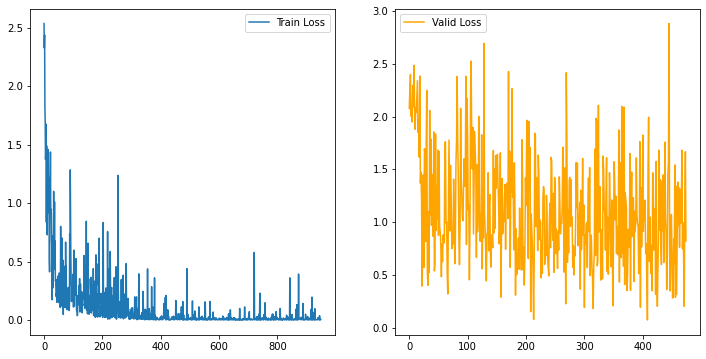

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
